In [0]:
import tensorflow as tf
import matplotlib.pylab as plt
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np


In [0]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [0]:
# download flower datasets using tensorflow datasets

In [4]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    with_info = True,
    as_supervised = True,
    split = ['train[:70%]', 'train[70%:]'],
)

num_training_examples = 0
num_validation_examples = 0
for example in training_set:
  num_training_examples += 1

for example in validation_set:
  num_validation_examples += 1

num_classes = dataset_info.features['label'].num_classes

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


In [5]:
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



In [6]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


In [0]:
IMAGE_RES = 224
def format_image(image,label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image,label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
# Do Simple Transfer Learning with TensorFlow Hub

In [0]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

feature_extractor = hub.KerasLayer(url, input_shape = (IMAGE_RES,IMAGE_RES,3))

In [0]:
feature_extractor.trainable = False

In [11]:
model = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

EPOCHS = 6

history = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data = validation_batches)

Epoch 1/6
81/81 [==============================] - 7s 83ms/step - loss: 1.2571 - accuracy: 0.6863 - val_loss: 1.1038 - val_accuracy: 0.8565
Epoch 2/6
81/81 [==============================] - 6s 76ms/step - loss: 1.0753 - accuracy: 0.8673 - val_loss: 1.0622 - val_accuracy: 0.8792
Epoch 3/6
81/81 [==============================] - 6s 75ms/step - loss: 1.0416 - accuracy: 0.8992 - val_loss: 1.0392 - val_accuracy: 0.8919
Epoch 4/6
81/81 [==============================] - 6s 77ms/step - loss: 1.0202 - accuracy: 0.9105 - val_loss: 1.0292 - val_accuracy: 0.8992
Epoch 5/6
81/81 [==============================] - 6s 78ms/step - loss: 1.0052 - accuracy: 0.9257 - val_loss: 1.0220 - val_accuracy: 0.9046
Epoch 6/6
81/81 [==============================] - 6s 75ms/step - loss: 0.9929 - accuracy: 0.9358 - val_loss: 1.0217 - val_accuracy: 0.9028


Text(0.5, 1.0, 'training and validation loss')

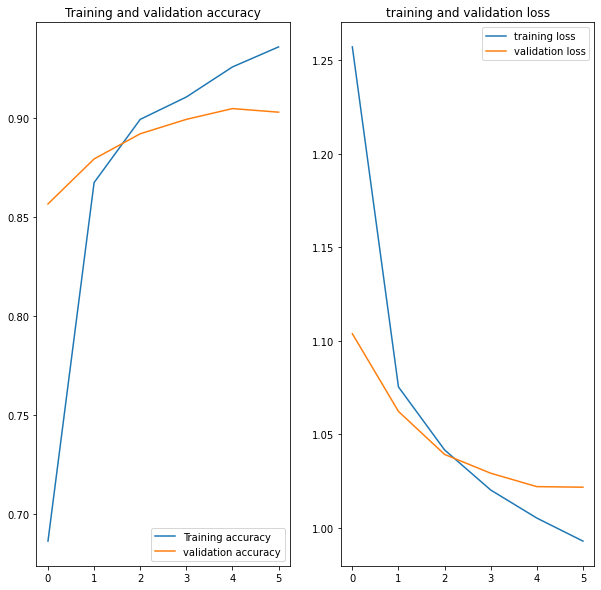

In [13]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training accuracy')
plt.plot(epochs_range, val_acc, label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='training loss')
plt.plot(epochs_range, val_loss, label = 'validation loss')
plt.legend(loc = 'upper right')
plt.title('training and validation loss')

In [0]:
# check the predictions

In [15]:
class_names = np.array(dataset_info.features['label'].names)
class_names

array(['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses'],
      dtype='<U10')

In [16]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis =-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['roses', 'dandelion', 'dandelion', 'dandelion', 'roses', 'tulips',
       'tulips', 'daisy', 'tulips', 'dandelion', 'daisy', 'tulips',
       'dandelion', 'dandelion', 'roses', 'tulips', 'dandelion',
       'dandelion', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'daisy',
       'dandelion', 'roses', 'sunflowers', 'daisy', 'roses', 'tulips',
       'dandelion', 'sunflowers', 'daisy'], dtype='<U10')

In [17]:
print('labels:', label_batch)
print('predicted labels:', predicted_ids)

labels: [4 0 0 0 4 2 2 1 2 0 1 2 0 0 4 2 0 0 1 0 2 3 1 0 4 3 1 4 2 0 3 1]
predicted labels: [4 0 0 0 4 2 2 1 2 0 1 2 0 0 4 2 0 0 1 0 2 3 1 0 4 3 1 4 2 0 3 1]


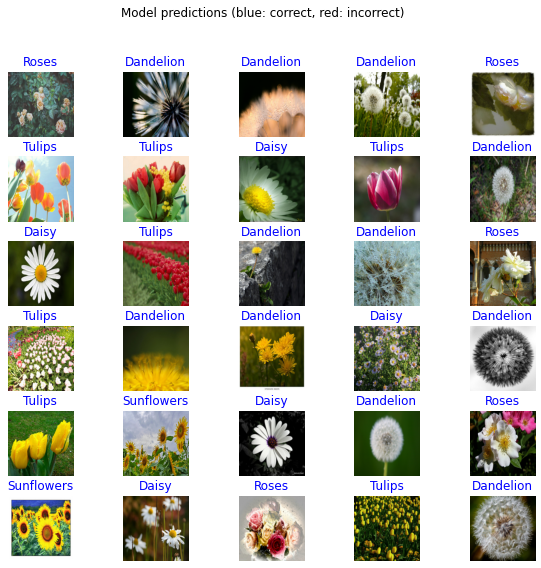

In [18]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

In [0]:
# code for another dataset

In [0]:
# IMAGE_RES = 299

# (training_set, validation_set), dataset_info = tfds.load(
#     'tf_flowers', 
#     with_info=True, 
#     as_supervised=True, 
#     split=['train[:70%]', 'train[70%:]'],
# )
# train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
# validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)

# URL = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"
# feature_extractor = hub.KerasLayer(URL,
#   input_shape=(IMAGE_RES, IMAGE_RES, 3),
#   trainable=False)

# model_inception = tf.keras.Sequential([
#   feature_extractor,
#   tf.keras.layers.Dense(num_classes)
# ])

# model_inception.summary()

In [0]:
# model_inception.compile(
#   optimizer='adam', 
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])

# EPOCHS = 6

# history = model_inception.fit(train_batches,
#                     epochs=EPOCHS,
#                     validation_data=validation_batches)